In [1]:
import yt
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

yt.set_log_level("error")
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams["text.usetex"] = True
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3.5
mpl.rcParams["xtick.direction"] = "out"
mpl.rcParams["ytick.direction"] = "out"
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["legend.fontsize"] = "small"

/home/bendp/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def format_axes(ax, xlab):
    ax[0,0].set_xlabel(xlab)
    ax[0,1].set_xlabel(xlab)
    ax[1,0].set_xlabel(xlab)
    ax[1,1].set_xlabel(xlab)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    ax[0,0].set_ylabel("Density, $\\rho$")
    ax[0,1].set_ylabel("Velocity, $v$")
    ax[1,0].set_ylabel("Pressure, $p$")
    ax[1,1].set_ylabel("Specific internal energy, $\epsilon$")

def get_conservative_field_names(dim):
    fields = ["x", "density", "mom_x", "energy"]
    if dim >= 2:
        fields.append("y")
        fields.append("mom_y")
    if dim >= 3:
        fields.append("z")
        fields.append("mom_z")
    return fields

def get_ray(adiabatic, rot, dim, ds):
    rot = np.deg2rad(rot)
    fields = get_conservative_field_names(dim)
    if dim == 1:
        ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0]).to_dataframe(fields)
    else:
        ray = ds.ray([0, 0.5 - 0.5*np.tan(rot), 0], [1, 0.5 + 0.5*np.tan(rot), 0]).to_dataframe(fields)
    size = np.array(ray["x"]).size
    if (dim < 2):
        ray["mom_y"] = np.zeros(size)
        ray["y"] = np.zeros(size)
    if (dim < 3):
       ray["mom_z"] = np.zeros(size)
       ray["z"] = np.zeros(size)

    if (dim == 1):
        ray["d"] = ray["x"]
    else:
        ray["d"] = (ray["x"] - 0.5)*np.cos(rot) + (ray["y"] - 0.5)*np.sin(rot) + 0.5
    ray["mom"] = np.sqrt(ray["mom_x"] * ray["mom_x"] + ray["mom_y"] * ray["mom_y"] + ray["mom_z"] * ray["mom_z"])
    ray["vel"] = ray["mom"] / ray["density"] * np.sign(ray["mom_x"])
    ray["int_energy"] = (ray["energy"] - 0.5 * ray["mom"] * ray["mom"] / ray["density"]) / ray["density"]
    ray["pressure"] = (adiabatic - 1) * ray["density"] * ray["int_energy"]
    return ray


def plot_four(ray, ax, fmt, label, **kwargs):    
    ax[0,0].plot(ray["d"],ray["density"],fmt,label=label, **kwargs)
    ax[0,1].plot(ray["d"],ray["vel"],fmt,label=label, **kwargs)
    ax[1,0].plot(ray["d"],ray["pressure"],fmt,label=label, **kwargs)
    ax[1,1].plot(ray["d"],ray["int_energy"],fmt,label=label, **kwargs)

# Takes an approximate solution and an exact solution with different resolutions and return an array of errors
def get_error(approx_soln, approx_x, exact_soln, exact_x):
    assert(approx_soln.size == approx_x.size)
    assert(exact_soln.size == exact_x.size)
    exact_interp = np.interp(approx_x, exact_x, exact_soln, np.NAN, np.NAN)
    return approx_soln - exact_interp

def get_dx(soln):
    return soln["x"][1] - soln["x"][0]

def error_norm(error, dx, ord):
    if (ord == np.inf):
        return np.abs(error).max()
    return np.power(np.power(np.abs(error), ord).sum() * dx.prod(), 1/ord)

# Live plots
## 1D tests

/tmp/ipykernel_66756/1840986614.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_66756/1840986614.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_66756/1840986614.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_66756/1840986614.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_66756/1840986614.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_66756/1840986614.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


advected sin convergence:
           dx  Density L1  L1 order  Density L2  L2 order  Density Linf  \
16   0.125000    0.319856       NaN    0.267387       NaN      0.316103   
32   0.062500    0.153616  1.058091    0.125549  1.090684      0.171322   
64   0.031250    0.065237  1.146827    0.054744  1.144081      0.076932   
128  0.015625    0.029641  1.143923    0.025126  1.137223      0.035486   

     Linf order  
16          NaN  
32     0.883684  
64     1.019371  
128    1.051684  


/tmp/ipykernel_66756/1840986614.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


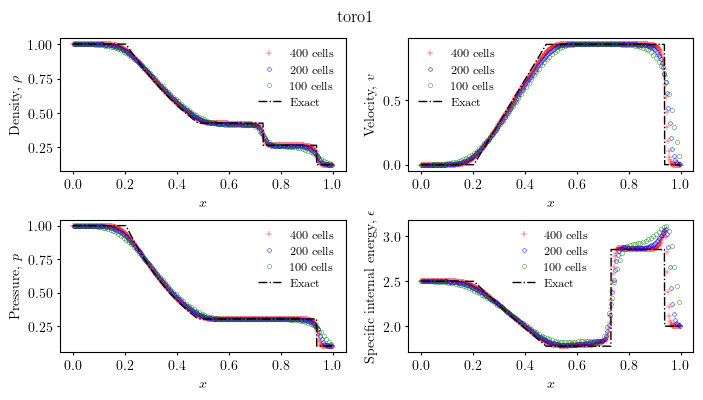

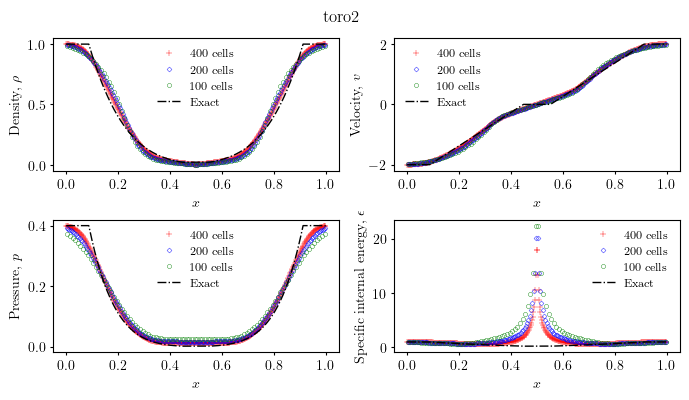

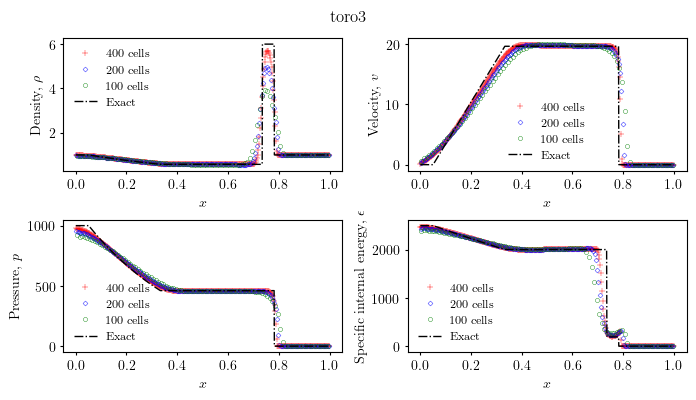

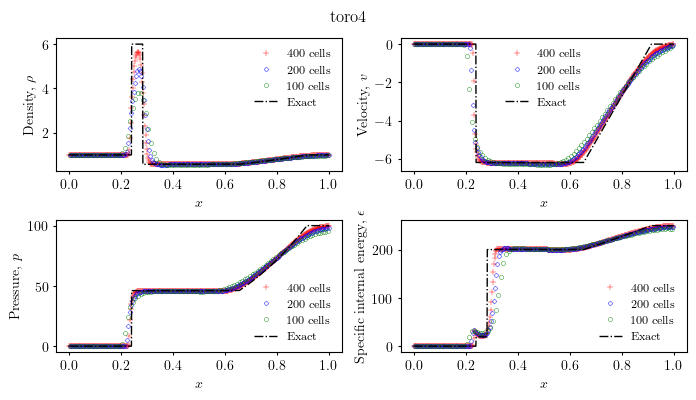

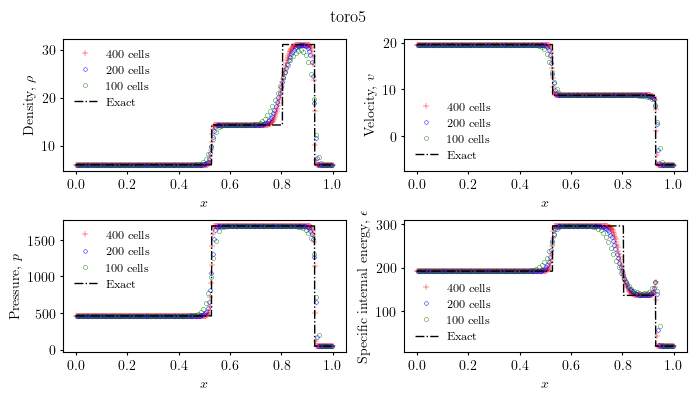

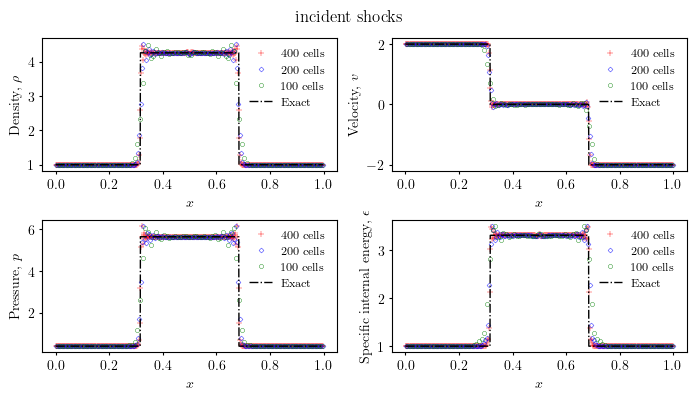

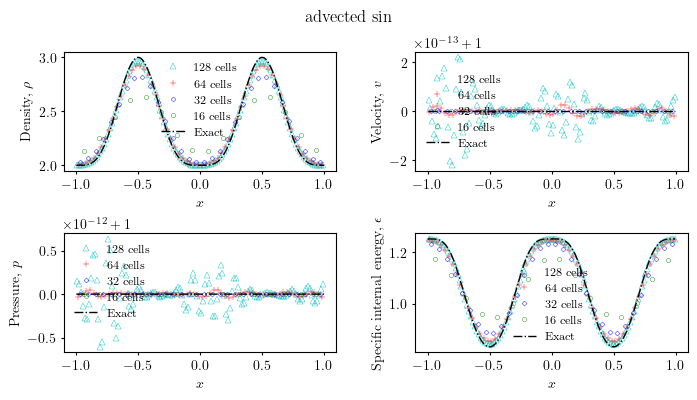

In [25]:
DIRECTORIES = ["build/Exec/RiemannProblem/output/test1/*",
               "build/Exec/RiemannProblem/output/test2/*",
               "build/Exec/RiemannProblem/output/test3/*",
               "build/Exec/RiemannProblem/output/test4/*",
               "build/Exec/RiemannProblem/output/test5/*",
               "build/Exec/RiemannProblem/output/test6/*",
               "build/Exec/SinProblem/output/*",
               "build/Exec/RiemannProblem2D/output/test1/35deg/*"]

EXACT_SOLN_EXISTS = [True, True, True, True, True, True, True, True]
COMPUTE_CONVERGENCE = [False, False, False, False, False, False, True, False]
NAMES = ["toro1", "toro2", "toro3", "toro4", "toro5", "incident shocks", "advected sin", "toro1, 35deg"]
ADIABATICS = [1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]
DIMS = [1, 1, 1, 1, 1, 1, 1, 2]
ROTS = [0, 0, 0, 0, 0, 0, 0, 35]

exact_fmt = "k-."
res_fmts = ["go", "bD", "r+", "c^", "yD", "ms"]
marker_sizes = [3, 2.5, 4, 4, 4, 4]

tests_to_plot = [0,1,2,3,4,5,6]

for i in tests_to_plot:
    TESTCASE = DIRECTORIES[i]
    SUBRUN_DIRS = sorted(glob.glob(TESTCASE))
    if (len(SUBRUN_DIRS) == 0):
        print (f"Cannot find results with pattern {DIRECTORIES[i]}")
        continue
    SUBRUN_FINAL_OUTPUTS = [sorted(glob.glob(SUBRUN_DIR+"/plt?????"))[-1] for SUBRUN_DIR in SUBRUN_DIRS]
    EXACT_SOLUTION = SUBRUN_DIRS[0] + "/pltEXACT_SOLN"
    adiabatic = ADIABATICS[i]
    dim = DIMS[i]
    rot = ROTS[i]
    fig, ax = plt.subplots(2, 2, figsize=(7,4))

    fig.suptitle(NAMES[i])

    num_solns = {}

    # plot numerical solution
    for ifile, plotfile in reversed(list(enumerate(SUBRUN_FINAL_OUTPUTS))):
        ds = yt.load(plotfile)
        label = f"{ds.domain_dimensions[0]} cells"

        # ray
        ray = get_ray(adiabatic, rot, dim, ds)
        plot_four(ray,ax,res_fmts[ifile],label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)
        if COMPUTE_CONVERGENCE[i]:
            num_solns[ds.domain_dimensions[0]] = ray

    # plot exact solution
    if (EXACT_SOLN_EXISTS[i]):
        label = "Exact"
        ds = yt.load(EXACT_SOLUTION)
        exact_ray = get_ray(adiabatic, 0, 1, ds)
        plot_four(exact_ray,ax,exact_fmt,label)

    if (COMPUTE_CONVERGENCE[i]):
        assert(EXACT_SOLN_EXISTS[i])
        print(NAMES[i] + " convergence:")

        df = pd.DataFrame(columns=["dx", "Density L1", "Density L2", "Density Linf"])
        for res in sorted(num_solns.keys()):
            soln = num_solns[res]
            soln["error_density"] = get_error(soln["density"], soln["x"], exact_ray["density"], exact_ray["x"])
            dx = get_dx(soln)
            ndx = np.array([dx])
            L1 = error_norm(soln["error_density"],ndx,1)
            L2 = error_norm(soln["error_density"],ndx,2)
            Linf = error_norm(soln["error_density"],ndx,np.inf)
            df.loc[res] = [dx, L1, L2, Linf]
        df.insert(2, "L1 order", np.log(df["Density L1"] / df["Density L1"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        df.insert(4, "L2 order", np.log(df["Density L2"] / df["Density L2"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        df.insert(6, "Linf order", np.log(df["Density Linf"] / df["Density Linf"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        print(df)

    # make plots pretty
    xlab = "$x$"
    format_axes(ax, xlab)

    fig.tight_layout(pad=0.8)
    fig.savefig(f"outputs/{NAMES[i]}.svg", dpi=300)
    fig.show()

# 2D tests
## Isentropic vortex - convergence

In [16]:
"""
Takes a yt box/region/data container and figures out the dimension of the problem
"""
def get_dim(data):
    assert(data.shape[0] > 1)
    if data.shape[1] == 1:
        assert(data.shape[2] == 1)
        return 1
    if data.shape[2] == 1:
        return 2
    return 3

"""
Takes a dataframe from and adds the primitive variables in
"""
def compute_primitives(data, dim, adiabatic):
    shape = data["x"].shape
    if dim < 2:
        data["y"] = np.zeros(shape)
        data["mom_y"] = np.zeros(shape)
    if dim < 3:
        data["z"] = np.zeros(shape)
        data["mom_z"] = np.zeros(shape)
    data["u"] = data["mom_x"] / data["density"]
    data["v"] = data["mom_y"] / data["density"]
    data["w"] = data["mom_z"] / data["density"]
    data["u_sq"] = data["u"] * data["u"] + data["v"] * data["v"] + data["w"] * data["w"]
    data["int_energy"] = (data["energy"] - 0.5 * data["density"] * data["u_sq"]) / data["density"]
    data["pressure"] = (adiabatic - 1) * (data["energy"] - 0.5 * data["density"] * data["u_sq"])

"""
Takes a yt data object and converts it to a DataFrame.
The fact I have to write this myself is very annoying, but the
to_dataframe() method provided by YT doesn't work for data in >1D...
"""
def to_dataframe(data):
    dim = get_dim(data)
    fields = get_conservative_field_names(dim)
    iterables = [range(0, data.shape[0]), range(0, data.shape[1]), range(0, data.shape[2])]
    index = pd.MultiIndex.from_product(iterables, names=["i","j","k"])
    entries = {}
    for field in fields:
        entries[field] = data[field].to_ndarray().flatten()
    return pd.DataFrame(entries, index=index)

"""
Takes the path to a plotfile and returns a DataFrame with primitive variables computed
"""
def open_plotfile(plotfile, adiabatic):
    ds = yt.load(plotfile)
    data = ds.covering_grid(level=ds.max_level, left_edge=ds.domain_left_edge,dims=ds.domain_dimensions*ds.relative_refinement(0,ds.max_level))
    dim = get_dim(data)
    data = to_dataframe(data)
    compute_primitives(data, dim, adiabatic)
    return data

"""
Computes the error norms for density, velocity and pressure using the plotfiles
provided and returns them in array form along with the cell spacing:

[dx, density L1, density L2, density Linf, u L1, u L2, u Linf, v L1, v L2, v Linf,
 w L1, w L2, w Linf, pressure L1, pressure L2, pressure Linf]
"""
def compute_error_norms(numerical_plotfile, exact_plotfile, adiabatic):
    # Load files
    num_data = open_plotfile(numerical_plotfile, adiabatic)
    exact_data = open_plotfile(exact_plotfile, adiabatic)
    assert(num_data.shape == exact_data.shape)
    dim = num_data.ndim

    # Get dx (remember that the covered grid has constant cell spacing)
    dx = [num_data["x"][1,0,0]-num_data["x"][0,0,0]]
    if (dim >= 2):
        dx.append(num_data["y"][0,1,0]-num_data["y"][0,0,0])
    if (dim == 3):
        dx.append(num_data["z"][0,0,1]-num_data["z"][0,0,0])
    dx = np.array(dx)

    # Now we can start computing errors

    ## The row returned should match:
    ## ["dx", "density L1", "density L2", "density Linf", "u L1", "u L2", "u Linf",
    ##  "v L1", "v L2", "v Linf", "w L1", "w L2", "w Linf",
    ##  "pressure L1", "pressure L2", "pressure Linf"]

    ## Fields to calculate errors for.
    ## Note that even in 1D v and w have been populated with zeros
    fields = ["density", "u", "v", "w", "pressure"]
    ## This is the row we'll add to the dataframe passed to this function
    row = [dx[0]]
    for field in fields:
        error = num_data[field] - exact_data[field]
        row.append(error_norm(error, dx, 1))
        row.append(error_norm(error, dx, 2))
        row.append(error_norm(error, dx, np.inf))
    return row

"""
Parameters
----------
test_dir : test case directory with a glob, for instance \"./build/Exec/IsentropicVortex/output/2d/*\"
    where inside that directory is subdirectories \"100\", \"200\", etc
"""
def get_convergence_properties(test_dir, adiabatic):
    SUBRUN_DIRS = sorted(glob.glob(test_dir))
    if (len(SUBRUN_DIRS) == 0):
        print (f"Cannot find results with pattern {test_dir}")
        return
    SUBRUN_FINAL_OUTPUTS = [sorted(glob.glob(SUBRUN_DIR+"/plt?????"))[-1] for SUBRUN_DIR in SUBRUN_DIRS]
    EXACT_SOLUTIONS = [SUBRUN_DIR + "/pltEXACT_SOLN" for SUBRUN_DIR in SUBRUN_DIRS]
    error_norms = []
    for i in range(len(SUBRUN_FINAL_OUTPUTS)):
        error_norms.append(compute_error_norms(SUBRUN_FINAL_OUTPUTS[i], EXACT_SOLUTIONS[i], adiabatic))
    df = pd.DataFrame(columns=["dx", "density L1", "density L2", "density Linf",
                               "u L1", "u L2", "u Linf", "v L1", "v L2", "v Linf",
                               "w L1", "w L2", "w Linf", "pressure L1", "pressure L2",
                               "pressure Linf"], data=error_norms)

    fields = ["density", "u", "v", "w", "pressure"]
    for ifield, field in enumerate(fields):
        df.insert(6 * ifield + 2, field + " L1 order", np.log(df[field + " L1"] / df[field + " L1"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        df.insert(6 * ifield + 4, field + " L2 order", np.log(df[field + " L2"] / df[field + " L2"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        df.insert(6 * ifield + 6, field + " Linf order", np.log(df[field + " Linf"] / df[field + " Linf"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))

    return df

    

DIRECTORIES = ["./build/Exec/IsentropicVortex/output/2d/*", "./build/Exec/IsentropicVortex/output/3d/*"]

for dir in DIRECTORIES:
    df = get_convergence_properties(dir, 1.4)
    print(df)

         dx  density L1  density L1 order  density L2  density L2 order  \
0  0.625000    0.826426               NaN    0.222157               NaN   
1  0.312500    0.466607          0.824677    0.132324          0.747504   
2  0.156250    0.270954          0.804419    0.072021          0.812544   
3  0.078125    0.151018          0.817389    0.038546          0.842313   

   density Linf  density Linf order      u L1  u L1 order      u L2  ...  \
0      0.175695                 NaN  2.671459         NaN  0.656982  ...   
1      0.112548            0.642534  1.590277     0.74835  0.399322  ...   
2      0.054913            0.838934  0.886853     0.79543  0.228753  ...   
3      0.025089            0.935977  0.475586     0.82995  0.124693  ...   

   w L2  w L2 order  w Linf  w Linf order  pressure L1  pressure L1 order  \
0   0.0         NaN     0.0           NaN     1.460345                NaN   
1   0.0         NaN     0.0           NaN     0.955342           0.612220   
2   0.0     

## Temporary code

In [5]:
BASE_FILENAMES = ["./build/Exec/RiemannProblem/output/test1/100/plt",
             "./build/Exec/RiemannProblem/output/test2/100/plt",
             "./build/Exec/RiemannProblem/output/test3/100/plt",
             "./build/Exec/RiemannProblem/output/test4/100/plt",
             "./build/Exec/RiemannProblem/output/test5/100/plt",
             "./build/Exec/SinProblem/output/128/plt"]
FILENAMES = [filename + "?????" for filename in BASE_FILENAMES]
EXACT_SOLN_FILENAMES = [filename + "EXACT_SOLN" for filename in BASE_FILENAMES]

adiabatic = 1.4

/tmp/ipykernel_4253/3285740553.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


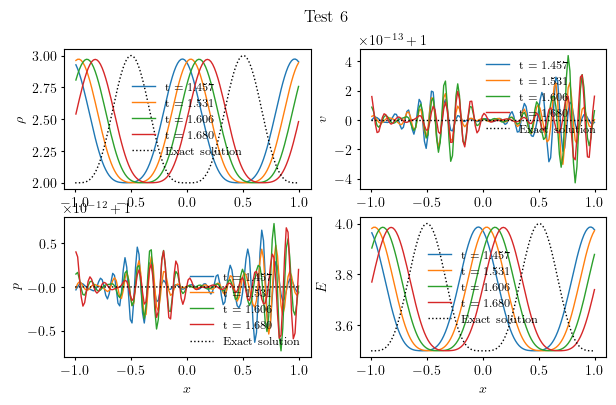

In [6]:
yt.set_log_level("error")
DIM = 1
# to_plot = [0,1,2,3,4]
to_plot = [5]
for i in to_plot:
    FILENAME = FILENAMES[i]
    ts = yt.load(FILENAME)

    fig,ax = plt.subplots(2,2, figsize=(7,4))
    for ds in ts[100:120:5]:
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            ray = ds.ray([x_centre,ds.domain_left_edge[1].value,0], [x_centre,ds.domain_right_edge[1].value,0])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        time_label = f"t = {ds.current_time.value:.3f}"
        # time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        # num_fmt = "bx"
        num_fmt = ""
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    #
    # Plot exact solution
    #
    exact = yt.load(EXACT_SOLN_FILENAMES[i])
    ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    mom = np.array(ray["mom_x"])
    x = np.array(ray["x"])
    density = np.array(ray["density"])
    energy = np.array(ray["energy"])
    vel_x = mom / density
    pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    exact_label = "Exact solution"
    exact_fmt = "k:"

    ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")
    fig.savefig(f"outputs/{i+1}.svg")
    fig.show()

## Cylindrical Explosion

/tmp/ipykernel_21379/648381014.py:87: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


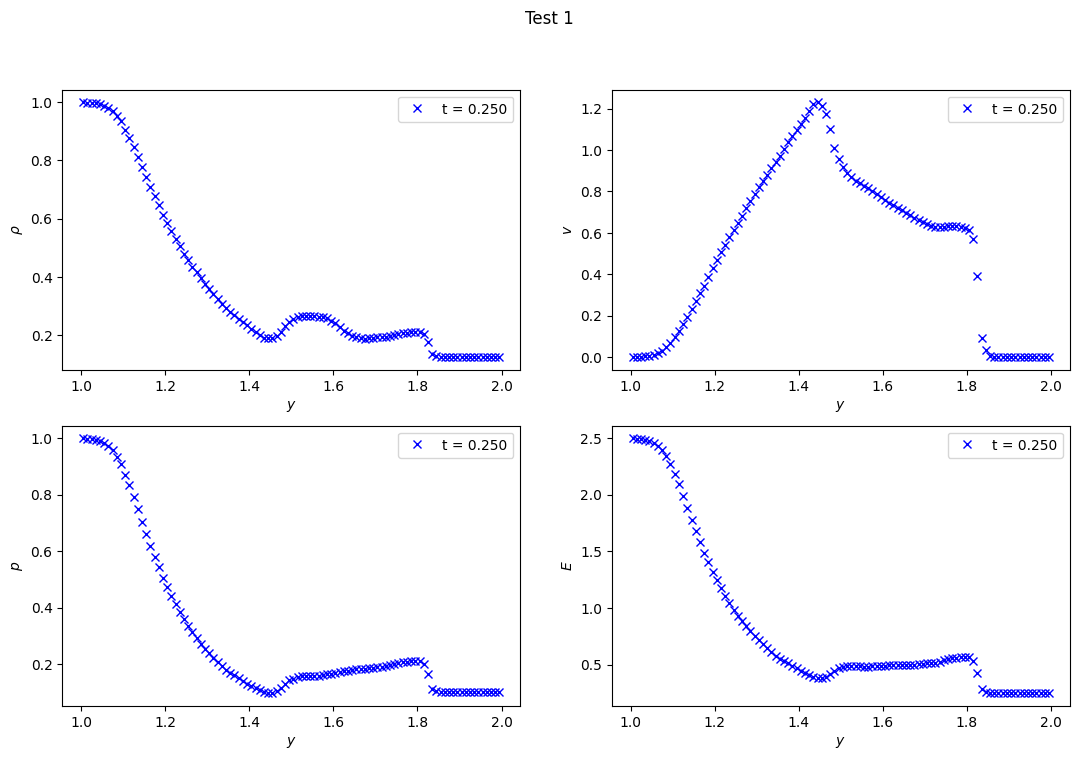

In [25]:
# BASE_FILENAMES = ["./outputs/cylindricalexplosion_200_3d/plt"]
# FILENAMES = [filename + "?????" for filename in BASE_FILENAMES]
FILENAMES = ["./outputs/cylindricalexplosion_200_3d/plt00065"]
# EXACT_SOLN_FILENAMES = [filename + "EXACT_SOLN" for filename in BASE_FILENAMES]

adiabatic = 1.4

yt.set_log_level("error")
DIM = 2
to_plot = [0]
for i in to_plot:
    FILENAME = FILENAMES[i]
    ts = yt.load(FILENAME)

    fig,ax = plt.subplots(2,2, figsize=(13,8))
    # for ds in ts[-2:-1]:
    for ds in [ts]:
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            y_centre = (ds.domain_left_edge[1].value + ds.domain_right_edge[1].value)/2
            z_centre = (ds.domain_left_edge[2].value + ds.domain_right_edge[2].value)/2
            ray = ds.ray([x_centre,y_centre,z_centre], [x_centre,ds.domain_right_edge[1].value,z_centre])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        time_label = f"t = {ds.current_time.value:.3f}"
        # time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        # num_fmt = "bx"
        num_fmt = "bx"
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    # #
    # # Plot exact solution
    # #
    # exact = yt.load(EXACT_SOLN_FILENAMES[i])
    # ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    # mom = np.array(ray["mom_x"])
    # x = np.array(ray["x"])
    # density = np.array(ray["density"])
    # energy = np.array(ray["energy"])
    # vel_x = mom / density
    # pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    # exact_label = "Exact solution"
    # exact_fmt = "k:"

    # ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    # ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    # ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    # ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")

    fig.show()

# Plotting existing results

/tmp/ipykernel_21379/4294276362.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


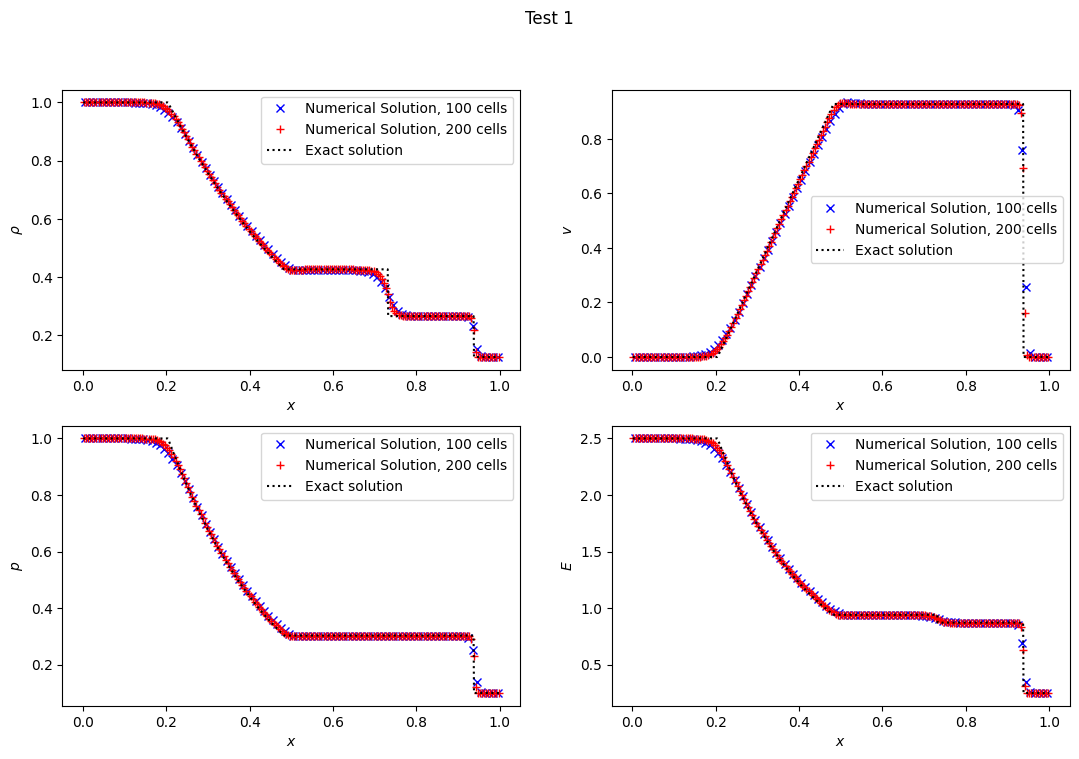

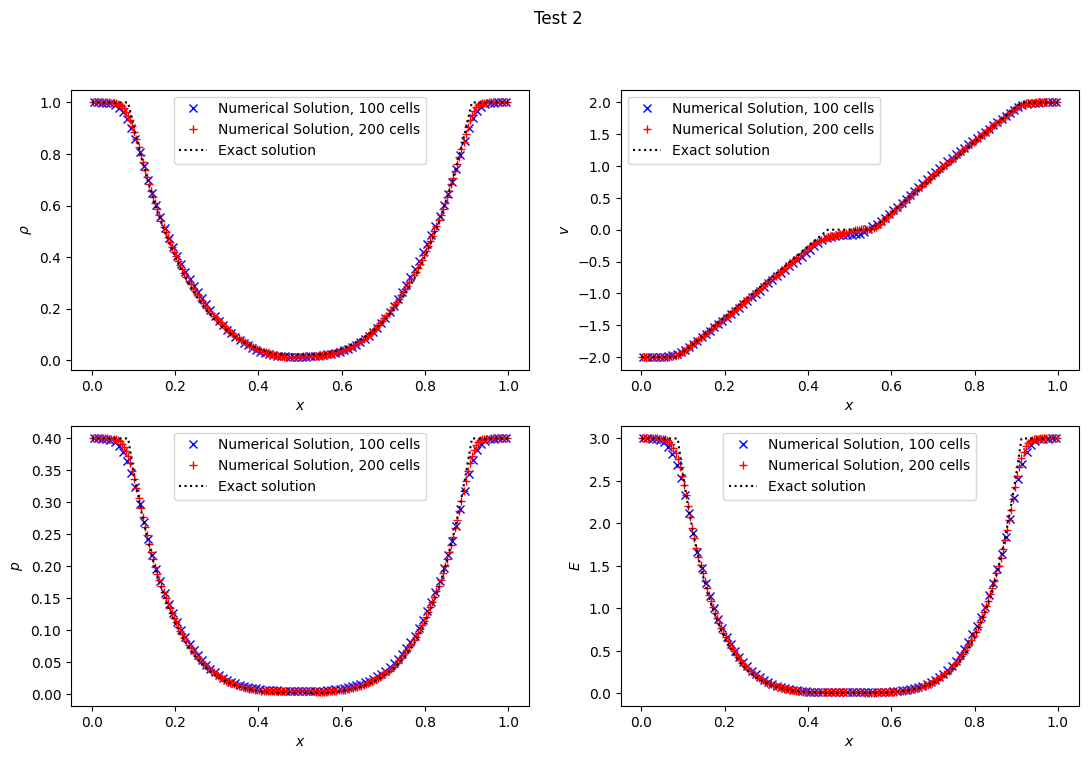

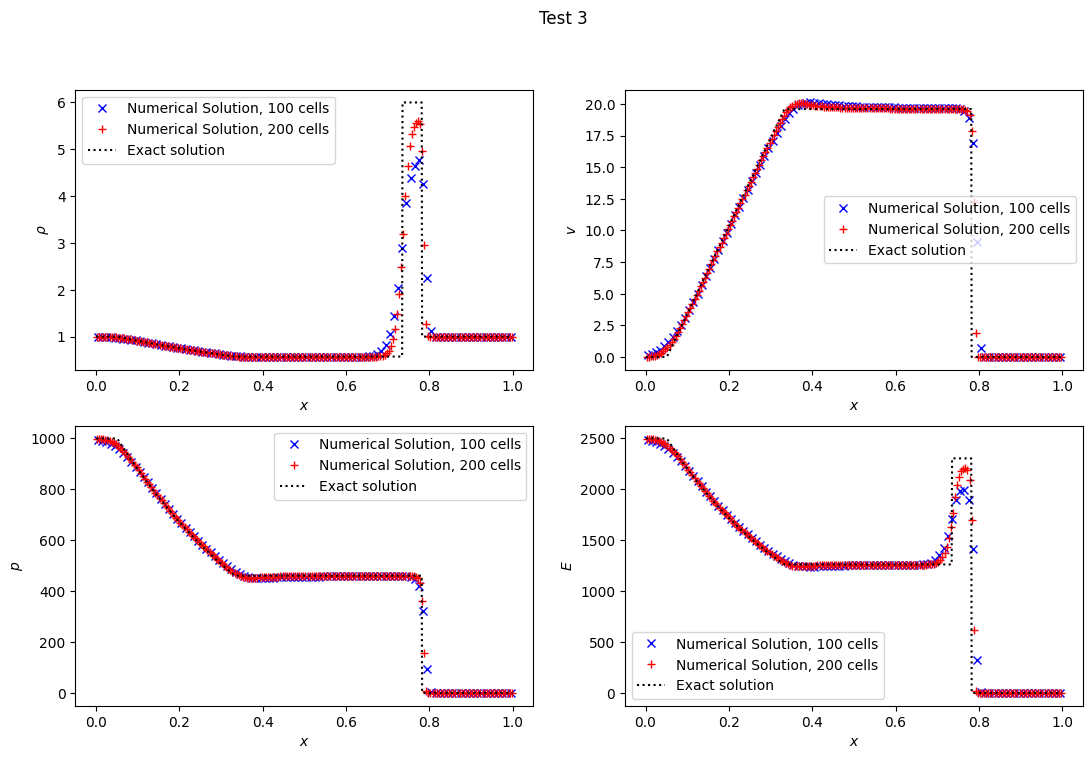

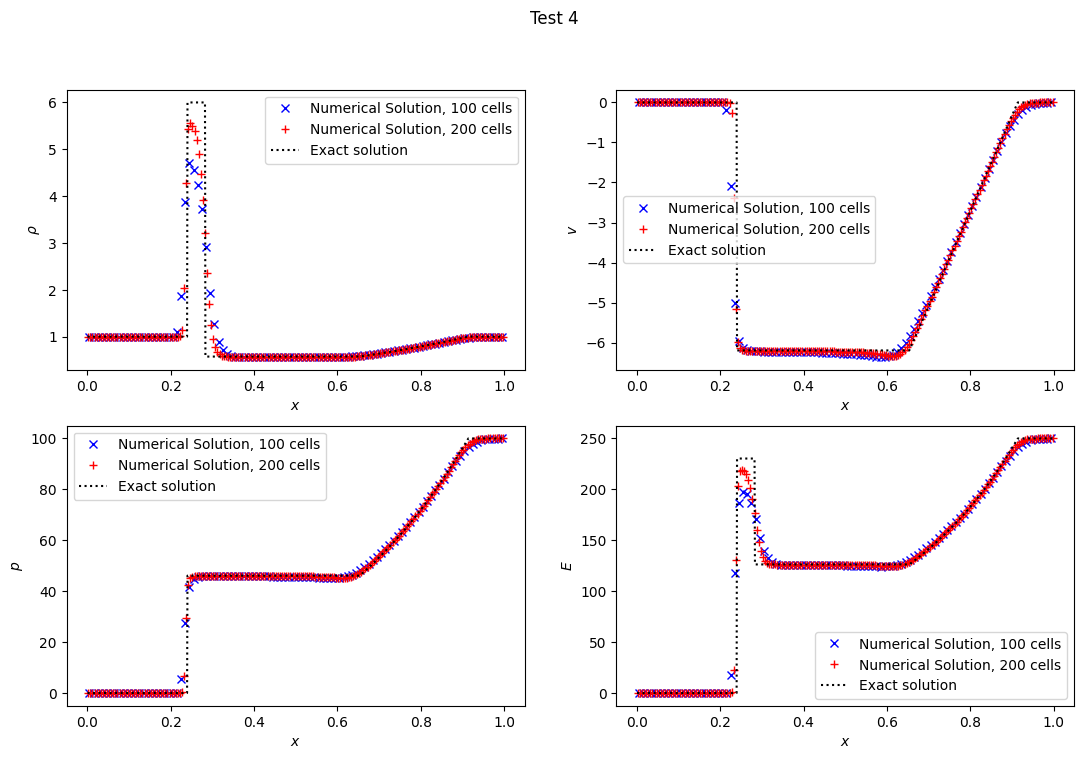

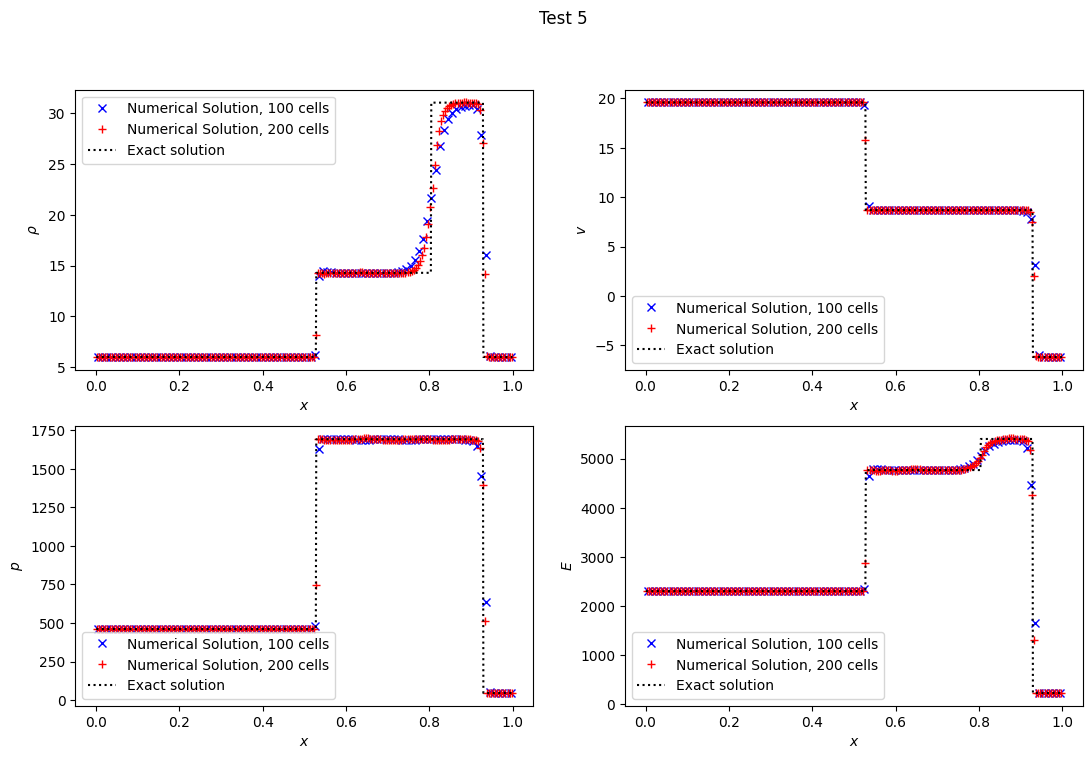

In [16]:
BASE_FILENAMES = [["./outputs/toro/muscl_hancock_100/test1/plt", "./outputs/toro/muscl_hancock_200/test1/plt"],
                  ["./outputs/toro/muscl_hancock_100/test2/plt", "./outputs/toro/muscl_hancock_200/test2/plt"],
                  ["./outputs/toro/muscl_hancock_100/test3/plt", "./outputs/toro/muscl_hancock_200/test3/plt"],
                  ["./outputs/toro/muscl_hancock_100/test4/plt", "./outputs/toro/muscl_hancock_200/test4/plt"],
                  ["./outputs/toro/muscl_hancock_100/test5/plt", "./outputs/toro/muscl_hancock_200/test5/plt"]]
FILENAMES = [[filename + "?????" for filename in subcase] for subcase in BASE_FILENAMES]
EXACT_SOLN_FILENAMES = [subcase[0] + "EXACT_SOLN" for subcase in BASE_FILENAMES]

adiabatic = 1.4

yt.set_log_level("error")
DIM = 1
to_plot = [0,1,2,3,4]
num_fmts = ["bx", "r+"]
for i in to_plot:
    subcase = FILENAMES[i]
    last_timestep_cases = []
    for FILENAME in subcase:
        ts = yt.load(FILENAME)
        last_timestep_cases.append(ts[-1])

    fig,ax = plt.subplots(2,2, figsize=(13,8))
    for subcase_no, ds in enumerate(last_timestep_cases):
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            ray = ds.ray([x_centre,ds.domain_left_edge[1].value,0], [x_centre,ds.domain_right_edge[1].value,0])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        # time_label = f"t = {ds.current_time.value:.3f}"
        time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        num_fmt = num_fmts[subcase_no]
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    #
    # Plot exact solution
    #
    exact = yt.load(EXACT_SOLN_FILENAMES[i])
    ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    mom = np.array(ray["mom_x"])
    x = np.array(ray["x"])
    density = np.array(ray["density"])
    energy = np.array(ray["energy"])
    vel_x = mom / density
    pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    exact_label = "Exact solution"
    exact_fmt = "k:"

    ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")

    fig.show()